# Benchmark transition from hub cells to terminal states

For simplicity of demonstration, we present the analysis steps for scale-1; the analysis for the other scales is identical.

In [1]:
from itertools import chain
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.plotting._significance import add_significance, get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

# General setting

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "mouse_neural_crest"

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [7]:
VELOCITY_METHODS = ["regvelo", "scvelo", "velovi"]

In [5]:
TERMINAL_STATE = ["Melanocytes", "enFib", "SC", "Sensory", "ChC", "SatGlia", "Gut_glia", "Gut_neuron", "Symp", "BCC"]

In [6]:
STATE_TRANSITIONS_RAW = [
    ("hub", "Sensory"),
    ("hub", "SatGlia"),
    ("hub", "SC"),
    ("hub", "Gut_glia"),
    ("hub", "Gut_neuron"),
    ("hub", "ChC"),
]

In [8]:
scale_level = 2

## Data loading

In [9]:
vks = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_stage_{scale_level}_{method}_all_regulons.h5ad")

    adata.obs["Hub"] = (~adata.obs["conflict"].astype(bool)) & (adata.obs["assignments"] == "none")
    adata.obs["assignments"] = adata.obs["assignments"].astype(str)
    adata.obs["assignments"][adata.obs["Hub"]] = "hub"

    print(adata)
    ## construct graph
    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    vks[method] = vk

AnnData object with n_obs × n_vars = 3926 × 1122
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'Hub'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assignments_colors', 'devtime_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'network', 'paga', 'regulators', 'skeleton', 

  0%|          | 0/3926 [00:00<?, ?cell/s]

  0%|          | 0/3926 [00:00<?, ?cell/s]

AnnData object with n_obs × n_vars = 3926 × 1122
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'Hub'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling'
    uns: 'assignments_colors', 'devtime_co

  0%|          | 0/3926 [00:00<?, ?cell/s]

  0%|          | 0/3926 [00:00<?, ?cell/s]

AnnData object with n_obs × n_vars = 3926 × 1122
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'Hub'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'TF', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'assignments_colors', 'devtime_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'network', 'paga', 'regulators',

  0%|          | 0/3926 [00:00<?, ?cell/s]

  0%|          | 0/3926 [00:00<?, ?cell/s]

## Filter out the transition

In [10]:
STATE_TRANSITIONS = []

for i in range(len(STATE_TRANSITIONS_RAW)):
    if STATE_TRANSITIONS_RAW[i][1] in np.unique(adata.obs["assignments"]):
        STATE_TRANSITIONS.append(STATE_TRANSITIONS_RAW[i])

In [11]:
STATE_TRANSITIONS_RAW = [f"{a} - {b}" for a, b in STATE_TRANSITIONS_RAW]

In [12]:
STATE_TRANSITIONS

[('hub', 'Sensory'), ('hub', 'SatGlia')]

## Measuring transport from hub to the terminal cell states

In [14]:
STATE_TRANSITIONS

[('hub', 'Sensory'), ('hub', 'SatGlia')]

In [15]:
cluster_key = "assignments"
rep = "X_pca"

score_df_rgv_vs_scv = []
score_df_rgv_vs_vi = []

cbc_rgv_f = []
cbc_scv_f = []
cbc_vi_f = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = vks["regvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = vks["scvelo"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_vi = vks["velovi"].cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df_rgv_vs_scv.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_scv + 1)),
            }
        )
    )

    score_df_rgv_vs_vi.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_vi + 1)),
            }
        )
    )

    cbc_rgv_f.append(cbc_rgv)
    cbc_scv_f.append(cbc_scv)
    cbc_vi_f.append(cbc_vi)

score_df_rgv_vs_scv_forward = pd.concat(score_df_rgv_vs_scv)
score_df_rgv_vs_vi_forward = pd.concat(score_df_rgv_vs_vi)

100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


## Comparing overall transition

In [20]:
dfs = []

g_df = pd.DataFrame({"CBC_forward": list(chain(*cbc_rgv_f))})
g_df["Method"] = "RegVelo"
dfs.append(g_df)

g_df = pd.DataFrame({"CBC_forward": list(chain(*cbc_vi_f))})
g_df["Method"] = "veloVI"
dfs.append(g_df)

g_df = pd.DataFrame({"CBC_forward": list(chain(*cbc_scv_f))})
g_df["Method"] = "scVelo"
dfs.append(g_df)

velo_df = pd.concat(dfs, axis=0)
velo_df["Method"] = velo_df["Method"].astype("category")

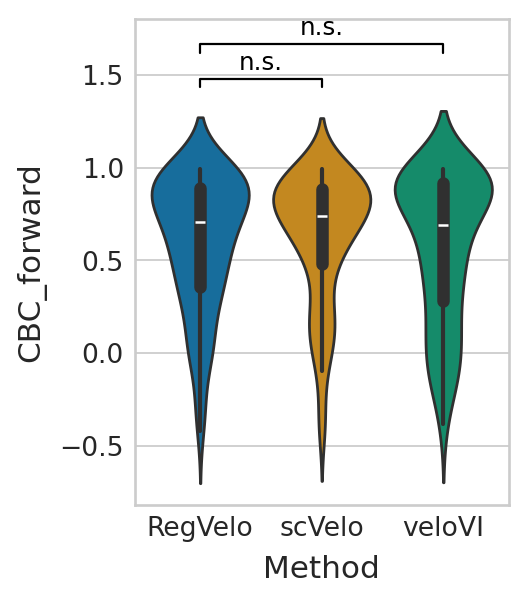

In [21]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.violinplot(data=velo_df, x="Method", y="CBC_forward", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(list(chain(*cbc_rgv_f)), list(chain(*cbc_vi_f)), equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(list(chain(*cbc_rgv_f)), list(chain(*cbc_scv_f)), equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    plt.show()

In [22]:
if SAVE_DATA:
    velo_df.to_csv(DATA_DIR / DATASET / "velo_df_scale_1.csv")

## Visualize all transition results

In [23]:
df_all = []
for i in range(1, 5):
    df = pd.read_csv(DATA_DIR / DATASET / f"velo_df_scale_{i}.csv", index_col=0)

    df["scale"] = str(i)
    df_all.append(df)

df = pd.concat(df_all, axis=0)
df

,CBC_forward,Method,scale
0,0.981314,RegVelo,1
1,0.476706,RegVelo,1
2,0.753209,RegVelo,1
3,0.548564,RegVelo,1
4,0.612676,RegVelo,1
...,...,...,...
609,0.491018,scVelo,4
610,0.174424,scVelo,4
611,0.297567,scVelo,4
612,-0.316798,scVelo,4


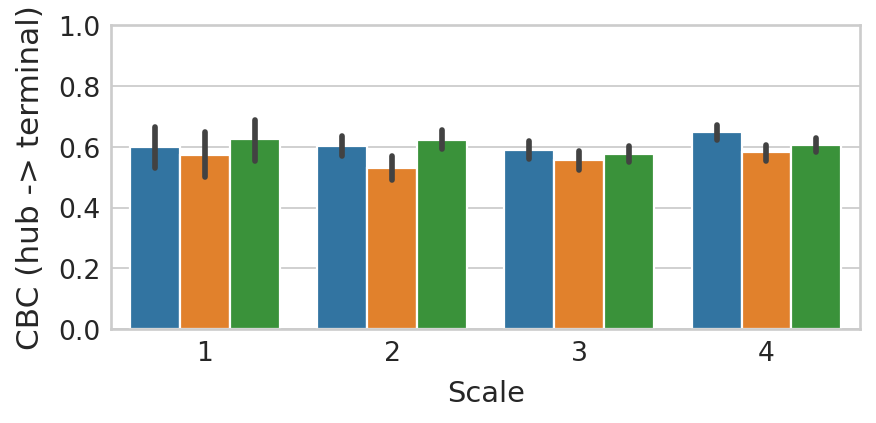

In [24]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 2.5))

    # Plot the barplot without error bars
    sns.barplot(data=df, x="scale", y="CBC_forward", hue="Method", ax=ax)

    # Add jittered dots
    # sns.stripplot(data=df, y="scale", x="AUROC", hue="method", dodge=True, color="black", ax=ax, jitter=True)

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2)

    # Customize labels and other settings
    ax.set(xlabel="", ylabel="CBC (hub -> terminal)")
    ax.set_xlabel(xlabel="Scale", fontsize=13)
    ax.set_ylim(0, 1)

    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / "CBC_benchmark.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()